<font size="85">New Brunswick 27° Gable Roof Building: Wind Tunnel Test</font> <br>
***
Feb 25, 2023

# Project description

The study building is a $27^\circ$ gable roof building with ridge height 9.8 m, width 14 m, and length 41 m. It is situated in a suburban surrounding all around except the North end. The North is exposed to an open terrain from the airport except for a couple of houses immediately next to it. 

| Parameter | Value |
| --- | --- |
| Geometric scale | 1:100 |
| Velocity scale | TBD |
| Sampling period | 180s |
| Sampling frequency | 500Hz |
| Reference wind tunnel speed | 60fps |
| Number of exposures to be tested | Two exposures |
| Profile measurement | Not required |
| Tunnel setup | The tunnel configurations for the two exposures are given in Table 1 |
| Pressure taps | 440 taps (see Figure 3 for the layout) |
| Number of scanners required | 30 |
| Test angles, $\theta$ | 0° to 350° at 10°; 45°; 135°; 225°; and 315°. (40 directions) |
| Number of runs | 8 (2 field conditions of Case 1, 6 for the other cases) |
| Other instrumentation | None |
| Dummy models | The dummy models will be built from the dense foam typically used by BLWTL to model surrounding buildings. |
| Turntable setup | Several neighboring buildings and trees close to the study building will be crudely modeled for Case 1. |


**Case matrix**
| Case | Name | Surround | Exp-2 | Exp-4 |
| --- | --- | --- | --- | --- |
| 1 | fld | X | X | X |
| 2 | iso |  | X |  |
| 3 | xd |  | X |  |
| 4 | xdd |  | X |  |
| 5 | dxd |  | X |  |
| 6 | xddd |  | X |  |
| 7 | dxdd |  | X |  |



## Basic definitions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

import wind
import windBLWT as wt
import windCAD

import winsound

### Files and directories

In [3]:
# Directories
rawHFPIdir = r"E:/nrcNB_windTunnelData/rawHFPI/"
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
rawVelDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/"
figDir = outputDir + r"__plots/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"


### General parameters

In [53]:
saveFigs = True
exps = ['E2',] #'E3']
cases = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

# exps = ['E2','E3']
# cases = ['c1', 'c2', 'c3',]


casesToRun = ['nrcNB'+case+exp for case in cases for exp in exps]
casedirs = [rawHFPIdir+caseToRun+r"/" for caseToRun in casesToRun]

# exp = exps[0]
# caseID = cases[1]

# caseToRun = 'nrcNB'+caseID+exp
# casedir = rawHFPIdir+caseToRun+r"/"


profileDir = rawVelDir #+'tng'+exp+'/'

In [5]:
for casedir in casedirs:
    if os.path.exists(casedir):
        print(casedir)
    else:
        raise FileNotFoundError(casedir)
# if os.path.exists(casedir):
#     print(casedir)
# else:
#     raise FileNotFoundError(casedir)

E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/
E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E3/


### Scaling
The geometric length scale is decided based on the optimal fitting the model in the wind tunnel.
$$ \lambda_L=1:100 $$

The velocity scale is calculated by assuming the design wind speed according to NBCC 2020. The values for Moncton, NB (the nearest available location to Dieppe, NB), are:
$$ q_{1/50}=0.5 kPa $$
$$ U_{10}=\sqrt{\frac{2q}{\rho}}=27.8 m/s $$

Assuming an approximate roof height wind speed at the model scale to be $U_H^{WT}=10m/s$ (will be updated after the test) and considering the roof height ($H=8m/s$) close enough to $10m$:
$$ \lambda_V= \frac{U_H^{WT}}{U_{10}}=1:2.78 $$

Thus, the time scale is:
$$ \lambda_T = \frac{\lambda_L}{\lambda_V} = 1:36 $$

$\implies$ the model scale duration equivalent to the full-scale $1hr$ is $100s$.

## Building Geometry

### Basic geometry

| Dimension | Unit |
| --- | --- |
| Length | $m$ |
| Time | $s$ |
| Velocity | $m/s$ |
| Density | $kg/m^3$ |

In [6]:
H = 80*wind.mm2m  # average roof height
Hr = 97.5*wind.mm2m  # ridge height
He = 62.5*wind.mm2m  # eaves height
Havg = np.mean([Hr, He])
B = 410*wind.mm2m
D = 138.7*wind.mm2m
roofSlope = 26.1  # roof slope

lScl=1/100.0
vScl=1/2.78
tScl=lScl

badTaps = []

### Basics of faces

In [7]:

tapData = pd.read_csv(tapFile, na_filter=False)

faceID = [1,2,3,4,5,6]
name = ['West_roof','East_roof','East_wall','North_wall','West_wall','South_wall']
note = ['','','','','','']
origin = [[0, -71.6, 62.5], [0, 71.6, 62.5], [0, 69.35, 0], [-205, 0, 0], [0, -69.35, 0], [205, 0, 0], ]

basisVectors = [
            [[1, 0, 0], [0, 0.898027575760616, 0.439939169855915], [0, -0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, -0.898027575760616, 0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
            [[0, -1, 0], [0, 0, 1], [-1, 0, 0]], 
            [[1, 0, 0], [0, 0, 1], [0, -1, 0]], 
            [[0, 1, 0], [0, 0, 1], [1, 0, 0]], 
            ]

# origin_plt = [[0, 79.6967], [0, -79.6967], [0, -223.5182], [-357.0189, 0], [0, -223.5182], [357.0189, 0], ]
origin_plt = [[0, -79.6967], [0, -79.6967], [0, -150], [0, -320], [0, -150], [0, -320], ]

basisVectors_plt = [
            [[1, 0], [0, 1]],       # Face 1 (West_roof)
            [[-1, 0], [0, -1]],     # Face 2 (East_roof)
            [[-1, 0], [0, -1]],     # Face 3 (East_wall)
            [[0, 1], [-1, 0]],      # Face 4 (North_wall)
            [[1, 0], [0, 1]],       # Face 5 (West_wall)
            [[0, -1], [1, 0]],      # Face 6 (South_wall)
            ]

vertices_basic = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 4
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 5
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 6
            ]

vertices_face_1a = [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], [51.85, 24.6713], 
                    [31.3, 0], [-55.6, 0], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ]
# vertices_face_1a = [[-207.25, 0], [-207.25, 79.6967], [-83.05, 79.6967], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ]
# vertices_face_1b = [[-55.6, 0], [-83.05, 24.6713], [-83.05, 79.6967], [51.85, 79.6967], [51.85, 24.6713], [31.3, 0], [-55.6, 0], ]
# vertices_face_1c = [[72.4, 0], [51.85, 24.6713], [51.85, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], ]

vertices_face_5a = [[-205, 0], [-205, 60.76], [-108.25, 60.76], [-108.25, 0], [-205, 0], ]
vertices_face_5b = [[-57.85, 0], [-57.85, 60.76], [33.55, 60.76], [33.55, 0], [-57.85, 0], ]
vertices_face_5c = [[70.15, 0], [70.15, 60.76], [205, 60.76], [205, 0], [70.15, 0], ]


### Zone dictionary


#### Case 2

In [8]:
zoneDict_basic = [
        {   # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [-193.38, 13.87, ], ])],
        #    11:['ASCE 7-22', 'Zone 3', np.array([[-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], ])],
        #    12:['ASCE 7-22', 'Zone 3', np.array([[207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], ])],
        #    13:['ASCE 7-22', 'Zone 2', np.array([[-207.25, 65.8267, ], [-207.25, 0, ], [-193.38, 0, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], ])],
        #    14:['ASCE 7-22', 'Zone 2', np.array([[207.25, 65.8267, ], [207.25, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [207.25, 65.8267, ], ])],
        #    15:['ASCE 7-22', 'Zone 2', np.array([[-193.38, 79.6967, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [-193.38, 79.6967, ], ])],
        #    16:['ASCE 7-22', 'Zone 1', np.array([[-193.38, 65.8267, ], [-193.38, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [-193.38, 13.87, ], ])],
        #    11:['ASCE 7-22', 'Zone 3', np.array([[-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], ])],
        #    12:['ASCE 7-22', 'Zone 3', np.array([[207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], ])],
        #    13:['ASCE 7-22', 'Zone 2', np.array([[-207.25, 65.8267, ], [-207.25, 0, ], [-193.38, 0, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], ])],
        #    14:['ASCE 7-22', 'Zone 2', np.array([[207.25, 65.8267, ], [207.25, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [207.25, 65.8267, ], ])],
        #    15:['ASCE 7-22', 'Zone 2', np.array([[-193.38, 79.6967, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [-193.38, 79.6967, ], ])],
        #    16:['ASCE 7-22', 'Zone 1', np.array([[-193.38, 65.8267, ], [-193.38, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[205, 60.76, ], [205, 0, ], [191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-191.13, 60.76, ], [-191.13, 0, ], [191.13, 0, ], [191.13, 60.76, ], [-191.13, 60.76, ], ])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-69.35, 61.8599, ], [-69.35, 0, ], [-55.48, 0, ], [-55.48, 68.6399, ], [-69.35, 61.8599, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[69.35, 61.8599, ], [69.35, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [69.35, 61.8599, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-55.48, 68.6399, ], [-55.48, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [0, 95.76, ], [-55.48, 68.6399, ], ])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[205, 60.76, ], [205, 0, ], [191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-191.13, 60.76, ], [-191.13, 0, ], [191.13, 0, ], [191.13, 60.76, ], [-191.13, 60.76, ], ])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-69.35, 61.8599, ], [-69.35, 0, ], [-55.48, 0, ], [-55.48, 68.6399, ], [-69.35, 61.8599, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[69.35, 61.8599, ], [69.35, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [69.35, 61.8599, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-55.48, 68.6399, ], [-55.48, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [0, 95.76, ], [-55.48, 68.6399, ], ])],
        },
]


zoneDict_face_1a = {   # Face 1a
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-95.0678, 13.87, ], [-110.5, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone s', np.array([[-55.6, 0, ], [-71.0322, 13.87, ], [42.853, 13.87, ], [31.3, 0, ], [-55.6, 0, ], ])],
           11:['NBCC 2020', 'Zone s', np.array([[72.4, 0, ], [60.847, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [72.4, 0, ], ])],
           12:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [60.847, 13.87, ], [51.85, 24.6713, ], 
                                                [42.853, 13.87, ], [-71.0322, 13.87, ], [-83.05, 24.6713, ], [-95.0678, 13.87, ], [-193.38, 13.87, ], ])],
        }

# zoneDict_face_1a = {   # Face 1a  (when the face is divided into 3 parts)
#             0:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
#             1:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
#             2:["NBCC 2020", "Zone s'", np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
#             3:["NBCC 2020", "Zone s'", np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
#             4:["NBCC 2020", "Zone s", np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-95.0678, 13.87, ], [-110.5, 0, ], [-193.38, 0, ], ])],
#             5:["NBCC 2020", "Zone s", np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-83.05, 79.6967, ], [-83.05, 65.8267, ], [-179.51, 65.8267, ], ])],
#             6:["NBCC 2020", "Zone r", np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-83.05, 65.8267, ], [-83.05, 24.6713, ], [-95.0678, 13.87, ], [-193.38, 13.87, ], ])],
#         }

zoneDict_face_5a = {   # Face 5a
            0:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-108.25, 60.76, ], [-108.25, 0, ], [-191.13, 0, ], ])],
        }
zoneDict_face_5b = {   # Face 5b
            0:['NBCC 2020', 'Zone w', np.array([[-57.85, 0, ], [-57.85, 60.76, ], [33.55, 60.76, ], [33.55, 0, ], [-57.85, 0, ], ])],
        }
zoneDict_face_5c = {   # Face 5c
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[70.15, 0, ], [70.15, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [70.15, 0, ], ])],
        }

### Face objects

In [9]:
# nominalPanelAreas = [4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas = [50.0, 200.0, 470.0, 785.0]

faces = []
for i,f in enumerate(faceID):
    print(f"Processing face {f}...")
    idx = tapData.index[tapData.faceID == f]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    tapName = tapData.tapName[idx]
    idxOrig = idx
    fc = windCAD.face(
                name=f'Face {f} ('+name[i]+')',
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=tapName,
                tapCoord=tapCoords,
                zoneDict=zoneDict_basic[i],
                nominalPanelAreas=nominalPanelAreas, 
                badTaps=badTaps,
                allBldgTaps=np.array(tapData.tapNo, dtype=int),
                )
    faces.append(fc)
    fc.error_in_panels
    print(f"Face {f} done.\n\n\n")


Processing face 1...
Generating panels ...
Reached the limit of wiggle factor of 1.5. Breaking the loop.
Reached the limit of wiggle factor of 1.5. Breaking the loop.
Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 200.0, 470.0, 785.0]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=200.0": [],
            "A=470.0": [],
            "A=785.0": []
        }
    },
    "NBCC 2020 -- Zone sp": {
        "nom. areas idxs with tiling errors [50.0, 200.0, 470.0, 785.0]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=200.0": [],
            "A=470.0": [],
            "A=785.0": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 200.0, 470.0, 785.0]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=200.0": [],
            "A=470.0": [],
      

In [10]:

i = 0
f = faceID[i]
idx = tapData.index[tapData.faceID == f]
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [414, 415, 606, 614, 615]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_1a = windCAD.face(
            name=f'Face {f} ('+name[i]+' with portico)',
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_1a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_1a,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:100: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
c:\ProgramData\Anaconda3\lib\site-packages\shapely\geometry\multipolygon.py:202: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  shell = ob[0]
c:\ProgramData\Anaconda3\lib\site-packages\shapely\geometry\multipolygon.py:203: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  holes = ob[1]


Generating panels ...
Reached the limit of wiggle factor of 1.5. Breaking the loop.


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:366: UserWarning: The sum of area weights 0.5987160479432252 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:366: UserWarning: The sum of area weights 0.37410852941350636 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:366: UserWarning: The sum of area weights 0 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 200.0, 470.0, 785.0]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=200.0": [],
            "A=470.0": [],
            "A=785.0": []
        }
    },
    "NBCC 2020 -- Zone sp": {
        "nom. areas idxs with tiling errors [50.0, 200.0, 470.0, 785.0]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=200.0": [],
            "A=470.0": [],
            "A=785.0": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 200.0, 470.0, 785.0]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=200.0": [],
            "A=470.0": [],
            "A=785.0": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [50.0, 200.0, 470.0, 785.0]": [],
        "tap idxs with 

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:366: UserWarning: The sum of area weights 0.5146223214091777 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:366: UserWarning: The sum of area weights 0.9985539593137672 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:366: UserWarning: The sum of area weights 0.9641885847068363 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of ar

In [11]:
i = 4
f = faceID[i]
idx = tapData.index[tapData.faceID == f].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 
                2511, 2512, 2513, 2514, 2515, 2516, 2601, 2602, 
                2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 
                2611, 2612, 2613, 2614, 2615, 2616]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5a = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5a,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )


i = 4
f = faceID[i]
idx = tapData.index[tapData.faceID == f].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2407, 2408, 
                2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 
                2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 
                2515, 2516, 
                2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 
                2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)
print(idx)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5b = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5b,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5b,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )


i = 4
f = faceID[i]
idx = tapData.index[tapData.faceID == f].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2407, 2408, 
                2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 
                2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 
                2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 
                2601, ]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5c = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5c,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5c,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

Generating panels ...
Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone e": {
        "nom. areas idxs with tiling errors [50.0, 200.0, 470.0, 785.0]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=200.0": [],
            "A=470.0": [],
            "A=785.0": []
        }
    },
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 200.0, 470.0, 785.0]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=200.0": [],
            "A=470.0": [],
            "A=785.0": []
        }
    }
}
Int64Index([392, 393, 394, 395, 396, 397], dtype='int64')
Generating panels ...
Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone w": {
        "nom. areas idxs with tiling errors [50.0, 200.0, 470.0, 785.0]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=200.0": [],
            "A=470.0": [],
            "A=

### Building objects

In [38]:

bldg_C1 = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=[face_1a, faces[1], faces[2], faces[3], face_5a, face_5b, face_5c, faces[5]],
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='Case 1 {x]',
                notes_Cp='Field case with the porticos.',
                badTaps=badTaps,
                )

bldg_C2 = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='Case 2 [x]',
                notes_Cp='Isolated.',
                badTaps=badTaps,
                )

bldg_C3 = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=[faces[0], faces[1], faces[3], faces[4], faces[5]],
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='Case 3 [x][]',
                notes_Cp='One of 2 spans instrumented.',
                badTaps=badTaps,
                )

bldg_C4 = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=[faces[0], faces[1], faces[3], faces[4], faces[5]],
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='Case 4 [x][][]',
                notes_Cp='First of 3 spans instrumentd.',
                badTaps=badTaps,
                )

bldg_C5 = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=[faces[0], faces[1], faces[3], faces[5]],
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='Case 5 [][x][]',
                notes_Cp='Second of 3 spans instrumented.',
                badTaps=badTaps,
                )

bldg_C6 = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=[faces[0], faces[1], faces[3], faces[4], faces[5]],
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='Case 6 [x][][][]',
                notes_Cp='First of 4 spans instrumented.',
                badTaps=badTaps,
                )

bldg_C7 = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=[faces[0], faces[1], faces[3], faces[5]],
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='Case 7 [][x][][]',
                notes_Cp='Second of 4 spans instrumented.',
                badTaps=badTaps,
                )

### Geometry plots

(-352.0, 352.0, -165.0, 165.0)

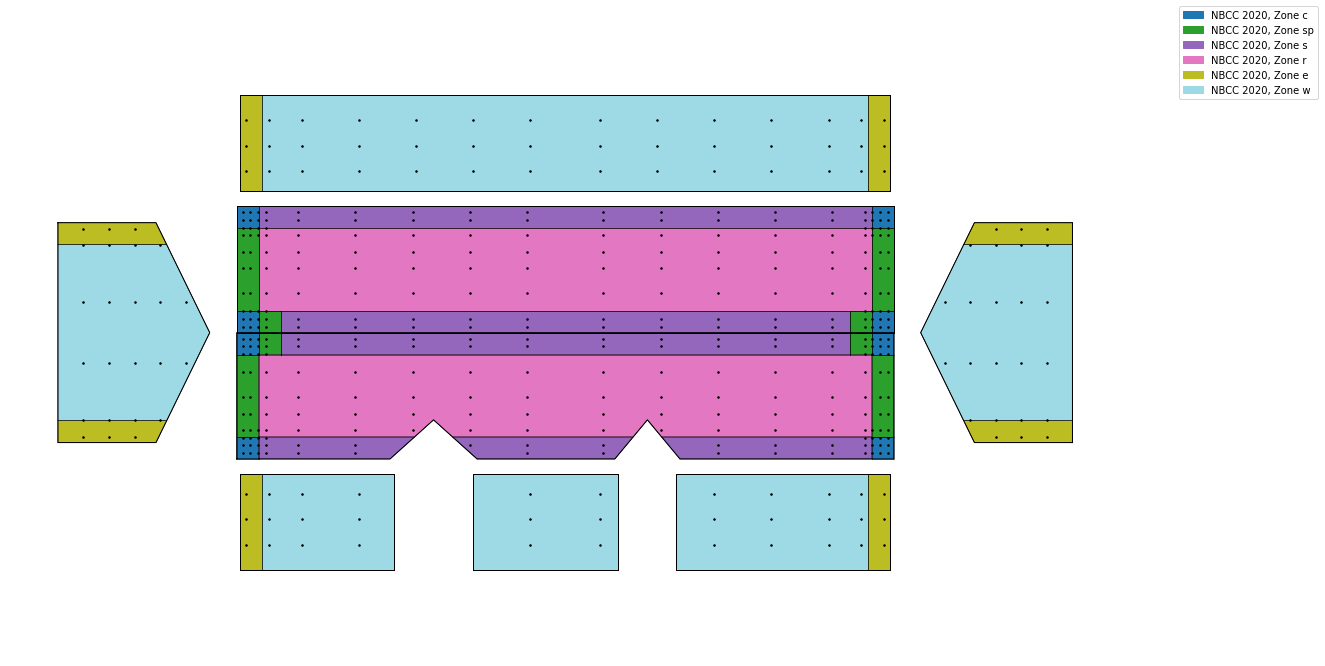

In [32]:
bldg = bldg['c1']

fig = plt.figure(figsize=[20,12])
ax = fig.add_subplot()

bldg.plotEdges(ax=ax,showName=False)
bldg.plotTaps(ax=ax,showTapNo=False)
bldg.plotZones(ax=ax)
# bldg.plotPanels(ax=ax,aIdx=0)
# bldg.plotTribs(ax=ax)
# bldg.plotPanels(ax=ax,aIdx=2)

ax.axis('equal')
ax.axis('off')
# if saveFigs:
#     fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')



## Wind field

### Exposure conditions

Tunnel configurations for the considered exposures

### Read data

In [21]:
sFreq = 1600
dt = 1/sFreq

pDir =profileDir+"tngE2/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_OP = wind.profile(name="BLWT - OP", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32,keepTH=True)

pDir =profileDir+"tngE3/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_SU = wind.profile(name="BLWT - SU", Z=Z,UofT=U_TH.transpose(),VofT=V_TH.transpose(),WofT=W_TH.transpose(),H=H,dt=dt,nSpectAvg=32,keepTH=True)

del(U_TH, V_TH, W_TH)

In [22]:
# if exp == 'E2':
#     vel_WT = vel_OP
# elif exp == 'E3':
#     vel_WT = vel_SU
z0_OP = 0.02
z0_OP = 0.2

es85 = wind.ESDU85(z0=0.02, Zref=H/lScl, Uref=25.0)
es74 = wind.ESDU74(z0=0.02, Zref=H/lScl, Uref=25.0)
vel_E2_ESDU = es85.toProfileObj()
vel_E2_ESDU.SpectH = es74.toProfileObj().SpectH
vel_E2_ESDU.name = r'ESDU ($z_0=0.02m$)'
vel_E2_ESDU.SpectH.name = r'ESDU ($z_0=0.02m$)'

es85 = wind.ESDU85(z0=0.2, Zref=H/lScl, Uref=25.0)
es74 = wind.ESDU74(z0=0.2, Zref=H/lScl, Uref=25.0)
vel_E3_ESDU = es85.toProfileObj()
vel_E3_ESDU.SpectH = es74.toProfileObj().SpectH
vel_E3_ESDU.name = r'ESDU ($z_0=0.2m$)'
vel_E3_ESDU.SpectH.name = r'ESDU ($z_0=0.2m$)'

vel = wind.Profiles([vel_OP, vel_E2_ESDU, vel_SU, vel_E3_ESDU])

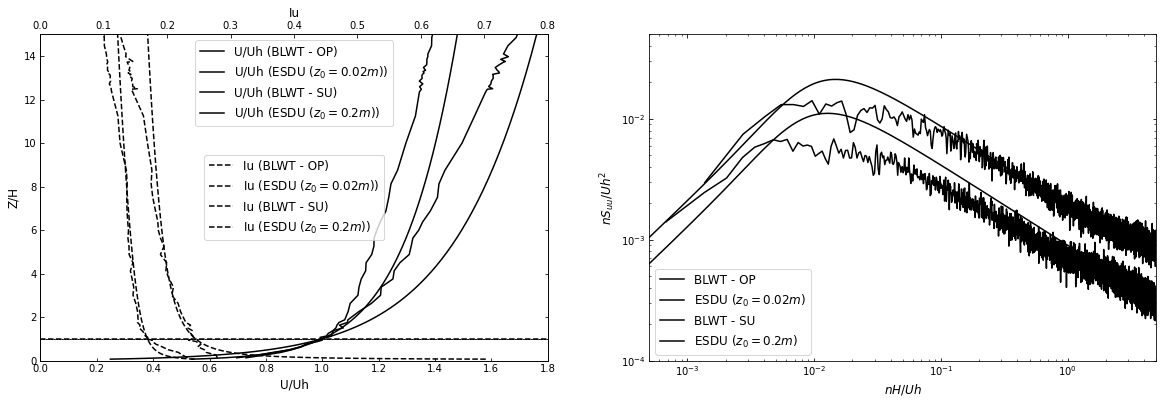

In [27]:
# print(np.shape(vel_OP.UofT))

# vStat = wind.get_velTH_stats(UofT=vel_OP.UofT, VofT=vel_OP.VofT, WofT=vel_OP.WofT,
#                              dt=vel_OP.dt, fields=wind.VALID_VELOCITY_STAT_FIELDS)

# kwargs = {}

# for k in vStat:
#     # print(np.shape(vStat[k]))
#     plt.figure()
#     plt.plot(vStat[k], vel_OP.Z, **kwargs)
#     plt.title(k)

# vel_OP.plotProfile_any('uw')
# vel_OP.plotProfile_basic1(figsize=[7,5], ylim=[0,5], U_lim=[0, 1.6], Iu_lim=[0, 0.8], )
# fig = vel_OP.plotProfile_basic2(ylim=[0,5], uw_lim=[0, 0.01], kwargs={'color': 'k', 'linestyle': '-'},)

# print(vel_OP.SpectH)
# fig = plt.figure(figsize=[6,6])
# ax = fig.add_subplot()
# vel_OP.SpectH.plotSpectra(fig=fig, axs=[ax,ax,ax], normalize=True, xLabel=r'$nH/Uh$', yLabel=r'$\frac{1}{n}\frac{dP}{d\ln(nH/Uh)}$')

vel.plot(
            figsize=[20,6], landscape=True,
            # figsize=[10,15], landscape=False,
            kwargs_profile={
                            'yLimits': [0,15], 
                            'xLimits_U': [0, 1.8], 
                            'xLimits_Iu': [0, 0.8],
                            # 'kwargs_U': {'color': 'k', 'linestyle': '-'},
                            # 'kwargs_Iu': {'color': 'k', 'linestyle': '--'},
                            # 'kwargs_legend_U': {'fontsize': 12, 'loc': 'upper center'},
                            # 'kwargs_ax': {'gridMajor':True, 'gridMinor':True}
                            }, 
            kwargs_spect={
                            'yLimits':[1e-4, 5e-2],
                            'xLimits': [5e-4, 5],
                            # 'kwargs_legend': {'fontsize': 12, 'loc': 'lower left'},
                            'kwargs_ax': {'gridMajor':True, 'gridMinor':True}
                            },)

### Plot wind field

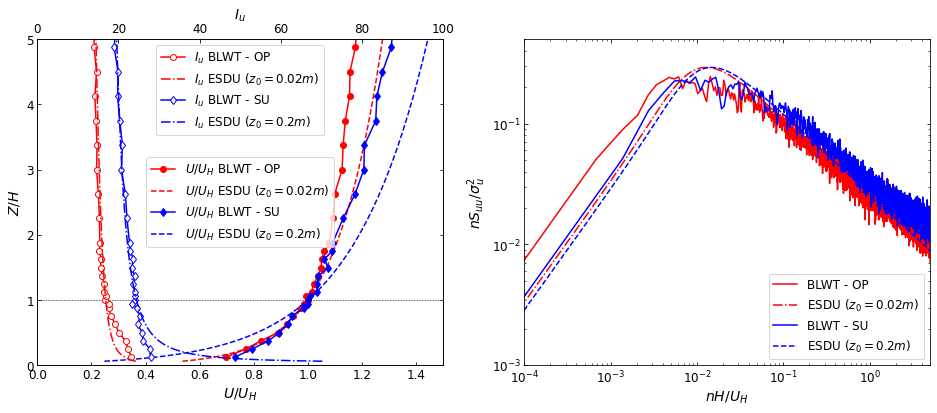

In [28]:
fig = vel.plot__(fig=plt.figure(figsize=[16,6]),zLim=[0,5], IuLim=[0,100], Ulim=[0,1.5],
        col=['r','r','b','b','g','g'],
        marker_Iu=   ['o','None','d','None','v','None'],
        linestyle_Iu=['-','-.',  '-','-.',  '-','--'],
        marker_U=    ['o','None','d','None','v','None'],
        linestyle_U= ['-','--',  '-','--',  '-','--'],
        marker_Spect=   ['None','None','None','None','None','None'],
        linestyle_Spect=['-','-.',  '-','--',  '-','--'],
        alpha_Spect=[0.5, 1.0, 0.5, 1.0],
        IuLgndLoc='upper center', UlgndLoc='center',
        fontSz_axLbl=14, fontSz_axNum=12, fontSz_lgnd=12,
        freqLim=[1e-4, 5], rSuuLim=[1e-3,0.5]
        )
# if saveFigs:
#     fig.savefig(figDir+"windField.svg",format='svg',dpi=1200, bbox_inches='tight')

## Surface pressure, $C_p$

### Read data

In [29]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 2909,
                'main_pitot_queue': 2910,
                '20inch_pitot_zero': 2907,
                '20inch_pitot_queue': 2908,
                'Uh_pitot_zero': 2905,
                'Uh_pitot_queue': 2906,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
# peakSpecs = {
#                 'method':'minmax',
#             }
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

In [39]:
caseIdx = 0
casedir = casedirs[caseIdx]
caseToRun = casesToRun[caseIdx]

cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)

cp_C1 = wind.bldgCp(
                bldgName=caseToRun,
                faces=bldg_C1.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName=caseToRun,
                refProfile=vel_OP,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)


In [ ]:
caseIdx = 1
casedir = casedirs[caseIdx]
caseToRun = casesToRun[caseIdx]

cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)

cp_C2 = wind.bldgCp(
                bldgName=caseToRun,
                faces=bldg_C2.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName=caseToRun,
                refProfile=vel_OP,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)

In [37]:
# cps = {}
# for c, (caseToRun, casedir, vel_WT) in enumerate(zip(casesToRun, casedirs, [vel_OP, vel_SU])):
#     cp_raw = wt.BLWTL_HFPI(
#         caseDir=casedir,
#         userNotes=None,
#         Z_MainPitot=1.48,
#         analogChannels_idxs=analogChannels_idxs,
#         pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
#         lowpassFreq=200.0,
#         # lowpassFreq=222.223,
#         Ntaps=440,
#     )
#     winsound.Beep(1000, 1000)

#     cp = wind.bldgCp(
#                     bldgName=caseToRun,
#                     faces=bldg[f'c{c+1}'].faces,
#                     H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
#                     caseName=caseToRun,
#                     refProfile=vel_WT,
#                     Zref_input=cp_raw.Z_MainPitot,
#                     Uref_input=cp_raw.Uref,
#                     samplingFreq=cp_raw.sampleRate,
#                     AoA=cp_raw.AoA,
#                     CpOfT=cp_raw.CpTH,
#                     badTaps=None,
#                     reReferenceCpToH=True,
#                     pOfT=None,
#                     p0ofT=None,
#                     CpStats=None,
#                     peakSpecs=peakSpecs,
#                     keepTH=False,
#                     )
#     winsound.Beep(1000, 1000)
#     cps[casesToRun] = (cp)

# winsound.Beep(2000, 1500)

# # print((cp_raw.CpTH.shape))
# # print(cp_raw.sampleRate)

TypeError: list indices must be integers or slices, not str

In [ ]:
from matplotlib.ticker import FuncFormatter

# fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
fld, fldrange, ticks = 'peakMin', [-8., 1.], np.linspace(-8,1.0,10)

fig = plt.figure(figsize=[13,8])
ax = plt.subplot()
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
cp.plotEdges(ax=ax, showName=False)
ax.axis('equal')
ax.axis('off')
# cbar = fig.colorbar(im[0], ax=ax, orientation='vertical',aspect=20,shrink=0.5,pad=0.0)
# cbar.set_label(fld+r" $C_p$", fontsize=14, rotation=270, labelpad=20)
# cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))
cbar = fig.colorbar(im[0], ax=ax, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.xaxis.set_label_position('top')
# cbar.ax.tick_params(labeltop=True, top=True)
# cbar.ax.set_ylabel('Label', rotation=270, labelpad=15)
# cbar.ax.set_title('Title', rotation=270, pad=20)
if saveFigs:
    fig.savefig(figDir+f"nrcNB{caseID}{exp}_Cp_{fld}.svg",format='svg',dpi=1200, bbox_inches='tight')



fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)

fig = plt.figure(figsize=[13,8])
ax = plt.subplot()
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
cp.plotEdges(ax=ax, showName=False)
ax.axis('equal')
ax.axis('off')
cbar = fig.colorbar(im[0], ax=ax, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.xaxis.set_label_position('top')
if saveFigs:
    fig.savefig(figDir+f"nrcNB{caseID}{exp}_Cp_{fld}.svg",format='svg',dpi=1200, bbox_inches='tight')

#### Wind tunnel data

### $C_p$ Plots

#### Local pressure

In [ ]:
# figs = cp.plotTapCpStatsPerAoA(xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.06),nCols=7, figsize=[20,20],mrkrs=['None','None','None'], fldRange=[-13,3])#,fields=['mean','std'])

tapsToPlot=[101, 111, 102, 112, 109, 110, 1911, 104, 106, 405, 314, 212, 316, 402, 301]
# figs = cp.plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot,
#                 xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.02),nCols=5, nRows=3, figsize=[12,6],mrkrs=['None','None','None'], fldRange=[-13,3],
#                 legend_bbox_to_anchor=(0.5, 0.95))#,fields=['mean','std'])

# if saveFigs:
#     for p,fig in enumerate(figs):
#         fig.savefig(figDir+f"nrcNB{caseID}{exp}_CpStatsPerAoA_pg_{p+1}.svg",format='svg',dpi=1200, bbox_inches='tight')


#### Field data

In [ ]:
fieldDataFile = r"D:/tempData_depot/NRC_data/newBrunswick_output/NewBrunswick_runBulk__Report_Stats.xlsx"
figDir2 = r"D:\OneDrive - The University of Western Ontario\Documents\Projects\NRC_fieldMonitoring\NRC_Docs\reports\figures/"

fs_vel = pd.read_excel(fieldDataFile, sheet_name='Velocity', header=0, index_col=0)

fs_meanCp = pd.read_excel(fieldDataFile, sheet_name='meanCp', header=0, index_col=0)

fs_minPeakCp = pd.read_excel(fieldDataFile, sheet_name='minPeakCp', header=0, index_col=0)

fs_maxPeakCp = pd.read_excel(fieldDataFile, sheet_name='maxPeakCp', header=0, index_col=0)

print(np.shape(fs_meanCp))

AoA = fs_vel['AoA [deg]'] - 5.0  # correct for the 5 deg offset in the field data
refH = 1.0

fs_data = {}
fs_data['mean'] = fs_meanCp.to_numpy()
fs_data['peakMin'] = fs_minPeakCp.to_numpy()
fs_data['peakMax'] = fs_maxPeakCp.to_numpy()


print(fs_vel)

In [ ]:
# fig = plt.figure(figsize=[13,8])
fig, axs = plt.subplots(3,3, figsize=[12,12], sharey=True)

zMax = 5
yticks = np.linspace(0,zMax,6)

fldLW = 1.2
esdd = wind.ESDU85(z0=0.9)
esField = esdd.toProfileObj()
H_FS = 9.81

ax = axs[0,0]
ax.plot(vel_OP.UbyUh, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.UbyUh, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.UbyUh, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.UbyUh, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(esField.UbyUh, esField.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.set_xlabel(r"$U/U_h$")
ax.set_ylabel(r"$z/H$")
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y:.1f}" for y in yticks])
ax.set_ylim([0,zMax])
wind.formatAxis(ax, gridMajor=False, gridMinor=False)

axs[0,1].axis('off')
axs[0,2].axis('off')

ax = axs[1,0]
# ax.plot(fs_vel['Iu'], np.ones_like(fs_vel['Iu']), '.k', label='Field')
ax.plot([0,0.5], [-100, -100], '-k', label='Field', linewidth=fldLW)
ax.plot(vel_OP.Iu, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.Iu, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.Iu, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.Iu, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(esField.Iu, esField.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['Iu'], vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
           boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW), 
           capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$I_u$")
ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,0.7])
ax.set_ylim([0,zMax])
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
# ax.legend()
wind.formatAxis(ax, gridMajor=False, gridMinor=False)
legend_handles, legend_labels = ax.get_legend_handles_labels()
fig.legend(legend_handles, legend_labels, loc='upper right', ncol=1, bbox_to_anchor=(0.6, 0.8), frameon=True)

ax = axs[1,1]
# ax.plot(fs_vel['Iv'], np.ones_like(fs_vel['Iv']), '.k', label='Field')
ax.plot(vel_OP.Iv, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.Iv, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.Iv, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.Iv, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(esField.Iv, esField.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['Iv'], vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
           boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW), 
           capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$I_v$")
# ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,0.5])
ax.set_ylim([0,zMax])
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
wind.formatAxis(ax, gridMajor=False, gridMinor=False)

ax = axs[1,2]
# ax.plot(fs_vel['Iw'], np.ones_like(fs_vel['Iw']), '.k', label='Field')
ax.plot(vel_OP.Iw, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.Iw, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.Iw, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.Iw, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(esField.Iw, esField.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['Iw'], vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
           boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW), 
           capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$I_w$")
# ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,0.5])
ax.set_ylim([0,zMax]) 
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
wind.formatAxis(ax, gridMajor=False, gridMinor=False)

ax = axs[2,0]
# ax.plot(fs_vel['xLu']/H_FS, np.ones_like(fs_vel['xLu']), '.k', label='Field')
ax.plot(vel_OP.xLuByH, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.xLuByH, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.xLuByH, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.xLuByH, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(esField.xLuByH, esField.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['xLu']/H_FS, vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
              boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW),
                capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$^xL_u/H$")
ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,50.0])
ax.set_ylim([0,zMax])
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
wind.formatAxis(ax, gridMajor=False, gridMinor=False)

ax = axs[2,1]
# ax.plot(fs_vel['xLu']/H_FS, np.ones_like(fs_vel['xLu']), '.k', label='Field')
ax.plot(vel_OP.xLvByH, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.xLvByH, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.xLvByH, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.xLvByH, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(esField.xLvByH, esField.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['xLv']/H_FS, vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
                boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW),
                capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$^xL_v/H$")
# ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,15.0])
ax.set_ylim([0,zMax])
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
wind.formatAxis(ax, gridMajor=False, gridMinor=False)

ax = axs[2,2]
# ax.plot(fs_vel['xLu']/H_FS, np.ones_like(fs_vel['xLu']), '.k', label='Field')
ax.plot(vel_OP.xLwByH, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.xLwByH, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.xLwByH, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.xLwByH, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(esField.xLwByH, esField.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['xLw']/H_FS, vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
                boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW),
                capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$^xL_w/H$")
# ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,8.0])
ax.set_ylim([0,zMax])
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
wind.formatAxis(ax, gridMajor=False, gridMinor=False)


fig.savefig(figDir2+f"windTunnel_vs_field__profiles.svg",format='svg',dpi=1200, bbox_inches='tight')

In [ ]:
# esdd = wind.ESDU85(z0=1.0)
# esprof = esdd.toProfileObj()

# print(esprof.stat_at_H(field='Iu'))

print(np.mean(fs_vel['Iu']))
print(np.mean(fs_vel['Iv']))
print(np.mean(fs_vel['Iw']))
print(np.mean(fs_vel['xLu']))
print(np.mean(fs_vel['xLv']))
print(np.mean(fs_vel['xLw']))
print(' --- ')
idx = [i for i in range(15) if i != 6]
print(idx)
print(np.max(fs_data['mean'][:,idx]))
print(np.min(fs_data['mean'][:,idx]))
print(np.mean(fs_data['mean'][:,idx]))
print(np.std(fs_data['mean'][:,idx]))

print(np.max(fs_data['peakMax'][:,idx]))
print(np.min(fs_data['peakMin'][:,idx]))


In [ ]:
idxs = cp.idxOfTapNum(tapsToPlot)
print(np.max(cps[1].CpStats['mean'][:,idxs]))

In [ ]:
idxs = cp.idxOfTapNum(tapsToPlot)

nrow, ncol = 4,4

fig, axs = plt.subplots(nrow, ncol, figsize=[15,15], sharey=True, sharex=True)

count = 0
for i in range(nrow):
    for j in range(ncol):
        ax = axs[i,j]
        if count < len(idxs):
            idx = idxs[count]
            if count != 6:
                ax.plot(AoA, fs_data['mean'][:,count], '.k', label='Mean Cp (Field)')
            ax.plot(cps[0].AoA, cps[0].CpStats['mean'][:,idx], '-k', label='Mean Cp (WT-OP)')
            ax.plot(cps[1].AoA, cps[1].CpStats['mean'][:,idx], '--k', label='Mean Cp (WT-SU)')
            ax.plot(AoA, fs_data['peakMin'][:,count], 'vr', label='PeakMin Cp (Field)', markersize=4, markerfacecolor='r')
            ax.plot(cps[0].AoA, cps[0].CpStats['peakMin'][:,idx], '-r', label='PeakMin Cp (WT-OP)')
            ax.plot(cps[1].AoA, cps[1].CpStats['peakMin'][:,idx], '--r', label='PeakMin Cp (WT-SU)')
            ax.plot(AoA, fs_data['peakMax'][:,count], '^g', label='PeakMax Cp (Field)', markersize=4, markerfacecolor='g')
            ax.plot(cps[0].AoA, cps[0].CpStats['peakMax'][:,idx], '-g', label='PeakMax Cp (WT-OP)')
            ax.plot(cps[1].AoA, cps[1].CpStats['peakMax'][:,idx], '--g', label='PeakMax Cp (WT-SU)')
            ax.set_title(cp.tapName[idx] + f" ({tapsToPlot[count]})")
        ax.set_ylim([-35,10])
        ax.set_xlim([0,360])
        ax.set_xticks([0,90,180,270,360])
        if i==nrow-1:
            ax.set_xlabel(r"AoA ($^\circ$)", fontsize=12)
        if j==0:
            ax.set_ylabel(r"$C_p$", fontsize=12)
        wind.formatAxis(ax, gridMajor=True, gridMinor=True)
        handles, labels = ax.get_legend_handles_labels()
        count += 1
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5,0.03), bbox_transform=fig.transFigure, fontsize=12)

# if saveFigs:
#     fig.savefig(figDir2+f"windTunnel-OP_vs_field_CpStats.svg",format='svg',dpi=1200, bbox_inches='tight')

In [ ]:
fig_OP = cp_C1.plotTapCpStatsPerAoA(#tapsToPlot=tapsToPlot,
                xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.04),nCols=5, nRows=3, figsize=[15,15],mrkrs=['None','None','None'], fldRange=[-25,10],legend_bbox_to_anchor=(0.5, 0.92),
                # overlayThis=fs_data, overlay_AoA=AoA, kwargs_overlay={'marker':'.','markersize':3,'linestyle':'None'},
                )

# fig_SU = cps[1].plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot,
#                 xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.04),nCols=5, nRows=3, figsize=[15,15],mrkrs=['None','None','None'], fldRange=[-25,10],legend_bbox_to_anchor=(0.5, 0.92),
#                 overlayThis=fs_data, overlay_AoA=AoA, kwargs_overlay={'marker':'.','markersize':3,'linestyle':'None'})

# if saveFigs:
#     fig_OP[0].savefig(figDir2+f"windTunnel-OP_vs_field.svg",format='svg',dpi=1200, bbox_inches='tight')
#     fig_SU[0].savefig(figDir2+f"windTunnel-SU_vs_field.svg",format='svg',dpi=1200, bbox_inches='tight')


#### Area averaged load

In [ ]:
NBCC_min = cp.zoneDict.copy()
NBCC_max = cp.zoneDict.copy()
# invDxnFactor = 1/0.85

print(f"{NBCC_min[0][0]} {NBCC_min[0][1]}")
NBCC_min[0][2] = {}     # Zone c
NBCC_min[0][2]['area'] = [0.1,1,10,100]
NBCC_min[0][2]['value'] = [-5,-5,-4,-4]

NBCC_min[1][2] = {}     # Zone sp
NBCC_min[1][2]['area'] = []
NBCC_min[1][2]['value'] = []

NBCC_min[2][2] = {}     # Zone s
NBCC_min[2][2]['area'] = [0.1,2.2,10,100]
NBCC_min[2][2]['value'] = [-3.6,-3.6,-2.65,-2.65]

NBCC_min[3][2] = {}     # Zone r
NBCC_min[3][2]['area'] = [0.1,0.85,10,100]
NBCC_min[3][2]['value'] = [-2.5,-2.5,-2,-2]

NBCC_min[4][2] = {}     # Zone e
NBCC_min[4][2]['area'] = [0.1,1,50,200]
NBCC_min[4][2]['value'] = [-2.1,-2.1,-1.5,-1.5]

NBCC_min[5][2] = {}     # Zone w
NBCC_min[5][2]['area'] = [0.1,1,50,200]
NBCC_min[5][2]['value'] = [-1.8,-1.8,-1.5,-1.5]



NBCC_max[0][2] = {}     # Zone c
NBCC_max[0][2]['area'] = [0.1,1,8.5,100]
NBCC_max[0][2]['value'] = [0.8,0.8,0.5,0.5]

NBCC_max[1][2] = NBCC_min[1][2]     # Zone sp

NBCC_max[2][2] = NBCC_max[0][2]    # Zone s
NBCC_max[3][2] = NBCC_max[0][2]    # Zone r

NBCC_max[4][2] = {}     # Zone e
NBCC_max[4][2]['area'] = [0.1,1,50,200]
NBCC_max[4][2]['value'] = [1.75,1.75,1.3,1.3]

NBCC_max[5][2] = NBCC_max[4][2]     # Zone w

print(NBCC_max)

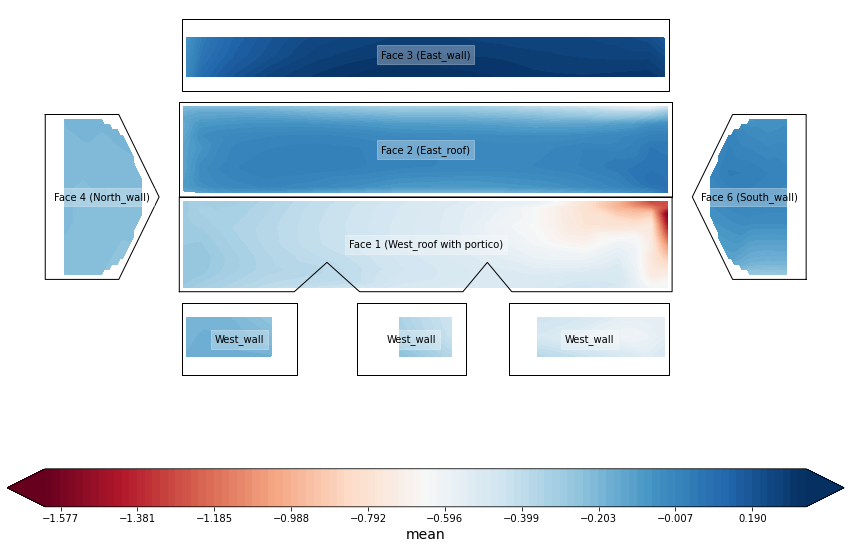

In [51]:
x = cp_C1.plotTapCpStatContour(fieldName='mean', dxnIdx=14, )

In [ ]:
areaFctr_FS = (1e-3/cp.lScl)**2
fig, _ = cp.plotAreaAveragedStat(figSize=[10,12], plotExtremesPerNominalArea=False, xLimits=[0.1, 200], yLimits=[-10, 4], areaFactor=areaFctr_FS, 
                                label_min='BLWT_min', label_max='BLWT_max', kwargs_legend={'loc':'upper right'},
                                kwargs_min={'color':'r','markersize':3,'marker':'v'}, kwargs_max={'color':'b','markersize':3,'marker':'^'},
                                plotZoneGeom=True, insetBounds=[0.5,0,0.5,0.4], nCols=2, invertYAxis=True,
                                overlayThis_min=NBCC_min, overlayThis_max=NBCC_max, overlayLabel_max='NBCC 2020',)

if saveFigs:
    fig.savefig(figDir+f"nrcNB{caseID}{exp}_CpCg.svg",format='svg',dpi=1200, bbox_inches='tight')

In [ ]:
a0 = 330.0
L = np.linspace(0.1, 50, 100)
# omega_0 = np.pi/2
f = (a0)/(4*L)

fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot()
ax.semilogy(L, f, 'k-')
ax.set_xlabel('L [m]')
ax.set_ylabel('First mode frequency [Hz]')
ax.set_xlim([0,50])
# ax.set_ylim([0,0.5])

_ = wind.formatAxis(ax, gridMajor=True, gridMinor=True)

figFile = r"D:\OneDrive - The University of Western Ontario\Documents\Projects\NRC_fieldMonitoring\NRC_Docs\reports\figures\L_vs_f.svg"
fig.savefig(figFile,format='svg',dpi=1200, bbox_inches='tight')
